### Equation Discovery

In [2]:
# set global variable to ensure correct mdof_sim loading
global script_type
script_type = "notebook"

# add parent directory to path
import sys
sys.path.append('..')
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import argparse
from tqdm.notebook import tqdm
from tqdm.auto import tqdm as tqdma
from datasets.create_dataset import create_dataset
from models.create_model import create_model
import numpy as np

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'mdof_sim'

In [14]:
def sort_data(vec2sort: np.ndarray, *data_: tuple[np.ndarray,...]):
    sort_ids = np.argsort(vec2sort)
    sorted_data_ = [None] * len(data_)
    for i, data in enumerate(data_):
        sorted_data_[i] = np.zeros_like(data)
        if len(data.shape)>1:
            for j in range(data.shape[1]):
                sorted_data_[i][:,j] = data[sort_ids,j]
        else:
            sorted_data_[i] = data[sort_ids]
    if len(data_) > 1:
        return tuple(sorted_data_), sort_ids
    else:
        return sorted_data_[0], sort_ids

In [15]:
def main(config: argparse.Namespace):
    torch.manual_seed(42)
    device = torch.device('cpu')

    # Create dataset
    phys_config = {
        'n_dof' : config.n_dof,
        'system-type' : config.system_type
    }
    data_parameters = {
        'sequence_length' : config.sequence_length,
        'subsample' : config.subsample,
        'downsample' : config.downsample
    }
    phases = ['train', 'val', 'test']
    full_dataset = create_dataset(phys_config, data_parameters)
    train_size = 1.0
    val_size = 0.0
    test_size = 0.0
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])
    datasets = {
        'train': train_dataset,
        'val': val_dataset,
        'test': test_dataset
    }
    dataloaders = {
        x: DataLoader(dataset=datasets[x], batch_size=config.batch_size, shuffle=True if x == 'train' else False, num_workers=config.num_workers, pin_memory=True) for x in phases}

    # Create pinn model
    if config.out_channels != 2*config.n_dof:
        raise Exception("Number of network outputs does not match state vector of simulated model")
    pinn_config = {
        'n_dof' : config.n_dof,
        'phys_system_type' : config.phys_system_type,
        'system_discovery' : config.system_discovery,
        'm_' : config.m_,
        'c_' : config.c_,
        'k_' : config.k_,
        'kn_' : config.kn_,
        'alphas' : full_dataset.alphas,
        'param_norms' : {
            'm' : 1.0,
            'c' : 1.0,
            'k' : 10.0,
            'kn' : 10.0
        }
    }
    model = create_model(config.model_type, config.in_channels, config.latent_features, config.out_channels, config.sequence_length, pinn_config)
    criterion = nn.MSELoss(reduction='sum')
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    model.set_switches(config.lambdas)

    # set up plotting and printing
    fig, axs = plt.subplots(3, 1, figsize=(12,12))
    dh = display.display(fig, display_id=True)
    loss_hist = []
    loss_hist_sub = []
    print_step = 1000
    num_obs_samps = len(datasets['train']) * config.sequence_length
    num_col_samps = len(datasets['train']) * config.subsample * config.sequence_length
    t_span_obs = torch.zeros((num_obs_samps)).numpy()  # time vector for observation domain
    obs_state = torch.zeros((num_obs_samps, 2 * config.n_dof))  # all state observations
    t_span_gt = torch.zeros((num_col_samps)).numpy()  # time vector for gt/prediction domain
    ground_truth = torch.zeros((num_col_samps, 3 * config.n_dof + 1)).numpy()  # all data for gound truth (state, time, force)
    predictions = torch.zeros((num_col_samps, 2 * config.n_dof)).numpy()  # all state predictions (same as collocation domain)

    # Training loop
    epoch = 0
    model = model.to(device)
    progress_bar = tqdm(total=config.num_epochs)
    while epoch < config.num_epochs:
        write_string = ''
        write_string += 'Epoch {}\n'.format(epoch)
        for phase in phases:
            phase_loss = 0.
            losses = [0.0] * 4
            write_string += '\tPhase {}\n'.format(phase)
            if phase == 'train':
                model.train()
            else:
                model.eval()
            for i, (sample, coll_data) in enumerate(dataloaders[phase]):
                # parse data sample
                state = sample[..., :2*config.n_dof].to(device).float().requires_grad_()
                t_span = sample[..., 2*config.n_dof].to(device).float().requires_grad_()
                t_coll = coll_data[..., 2*config.n_dof].to(device).float().requires_grad_()
                force = coll_data[..., 2*config.n_dof+1:].to(device).float().requires_grad_()

                inputs = t_span
                targets = state
                t_coll = t_coll.reshape(-1,config.sequence_length)  # unrolls collocation data
                force = force.reshape(-1,config.sequence_length,config.n_dof)

                if phase == 'train':
                    optimizer.zero_grad()
                loss, losses_i, _ = model.loss_func(config.lambdas, inputs, targets, t_coll, force, epoch)
                phase_loss += loss.item()
                losses = [losses[j] + loss_i for j, loss_i in enumerate(losses_i)]
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    # model.apply(clipper)
            if phase == 'train':
                loss_hist.append([loss_it.item() for loss_it in losses] + [phase_loss])
            write_string += '\tLoss {}\n'.format(phase_loss)
        if config.system_discovery:
            write_string += '\tSystem Parameters:\tc - {:.4f} [{:.2f}]\tk - {:.4f} [{:.2f}]\tkn - {:.4f} [{:.2f}]\n'.format(
                model.c_[0,0].item()*pinn_config['param_norms']['c'],
                config.c_[0,0].item(),
                model.k_[0,0].item()*pinn_config['param_norms']['k'],
                config.k_[0,0].item(),
                model.kn_[0,0].item()*pinn_config['param_norms']['kn'],
                config.kn_[0,0].item())
        
        if (epoch+1) % print_step == 0:

            for i, (sample, coll_data) in enumerate(dataloaders['train']):
                inpoint_obs = i * config.batch_size * config.sequence_length
                outpoint_obs = (i+1) * config.batch_size * config.sequence_length
                inpoint_col = i * config.batch_size * config.subsample * config.sequence_length
                outpoint_col = (i+1) * config.batch_size * config.subsample * config.sequence_length

                obs_inputs = sample[..., 2 * config.n_dof].to(device).float()
                t_span_obs[inpoint_obs:outpoint_obs] = obs_inputs.numpy().reshape(-1)
                obs_state[inpoint_obs:outpoint_obs,:] = sample[..., :2 * config.n_dof].float().reshape(-1,2*config.n_dof)

                t_coll = coll_data[..., 2 * config.n_dof].to(device).float().requires_grad_()
                pred_inputs = t_coll.reshape(-1, config.sequence_length)

                ground_truth[inpoint_col:outpoint_col,:] = coll_data.reshape(-1, 3 * config.n_dof + 1).cpu().numpy()
                t_span_gt[inpoint_col:outpoint_col] = pred_inputs.reshape(-1).detach().cpu().numpy()
                predictions[inpoint_col:outpoint_col, :] = model(pred_inputs).detach().cpu().reshape(-1, 2 * config.n_dof).numpy()

            (ground_truth, predictions, t_span_gt), _ = sort_data(t_span_gt, ground_truth, predictions, t_span_gt)
            (obs_state, t_span_obs), _ = sort_data(t_span_obs, obs_state, t_span_obs)

            for kinetic in range(2):
                axs[kinetic].cla()
                axs[kinetic].plot(t_span_gt * model.alpha_t.item(),
                                  ground_truth[:, kinetic] * model.alpha_z[kinetic].item(),
                                  label='Exact Solution', color='tab:blue', linewidth=1.0)
                axs[kinetic].plot(t_span_gt * model.alpha_t.item(),
                                  predictions[:, kinetic] * model.alpha_z[kinetic].item(),
                                  label='Prediction', linestyle='--', color='tab:red', linewidth=1.0)
                axs[kinetic].plot(t_span_obs * model.alpha_t.item(),
                                  obs_state[:, kinetic] * model.alpha_z[kinetic].item(),
                                  label='Observation Data', linestyle='None', marker='o',
                                  color='tab:gray', markersize=4)
                axs[kinetic].legend()

            loss_vec = torch.arange(epoch+1)
            loss_step = len(loss_hist) // int(10e3) + 1
            loss_vec = loss_vec[::loss_step]
            loss_hist_sub = loss_hist_sub + loss_hist[::loss_step]
            loss_hist = []

            axs[2].cla()
            linestyles = ['-'] * 4 + ['--']
            colors = ['tab:blue', 'tab:purple', 'tab:red', 'tab:green', 'black']
            labels = ['Observation', 'Continuity', 'Physics', 'IC', 'Total']
            axs[2].set_prop_cycle(linestyle=linestyles, color=colors)
            axs[2].plot(loss_vec,loss_hist_sub)
            axs[2].legend(labels)
            axs[2].set_yscale('log')

            dh.update(fig)
            tqdma.write(write_string)
            
        epoch += 1
        progress_bar.update(1)
    
    progress_bar.close()

    return model

Simulating 1DOF Duffing oscillator...
Setting\instantiating physical parameters in PINN....
Setting normalisation constants....
Setting loss function switches....


/opt/homebrew/Caskroom/miniforge/base/envs/pytorch2-py310/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "
/opt/homebrew/Caskroom/miniforge/base/envs/pytorch2-py310/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


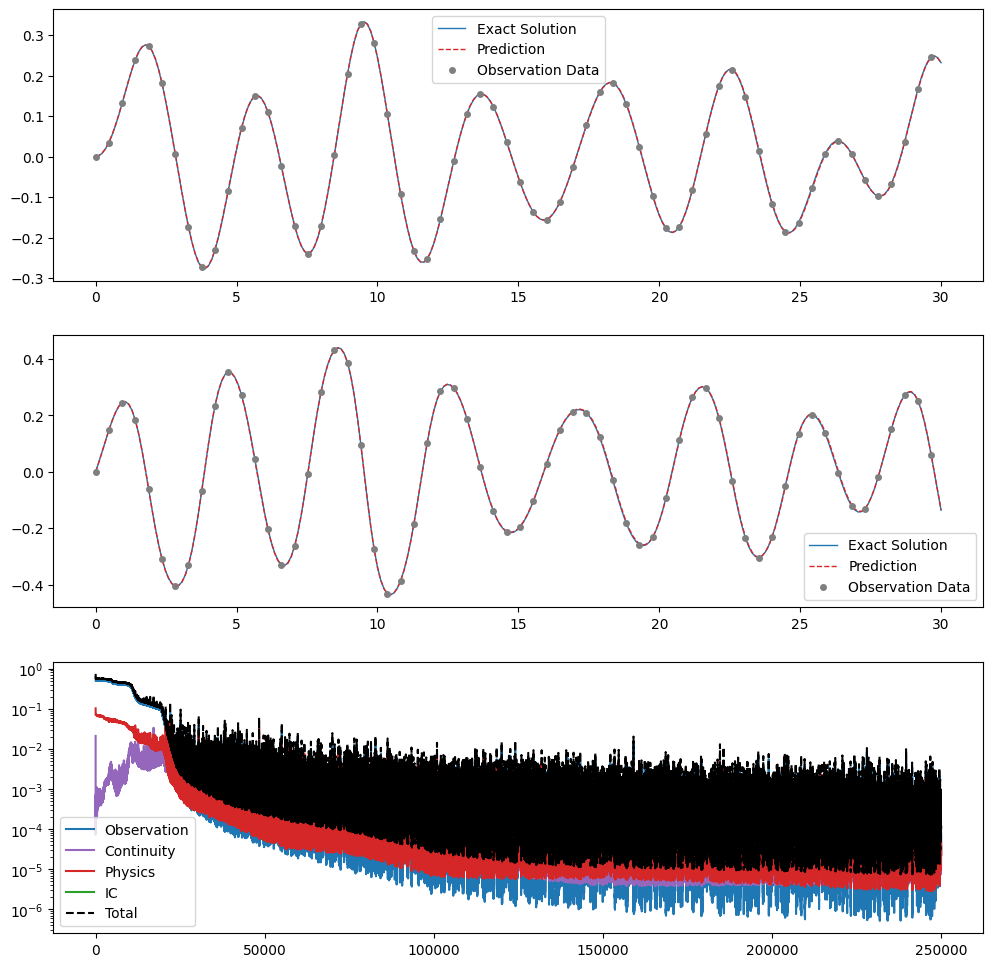

  0%|          | 0/250000 [00:00<?, ?it/s]

Epoch 999
	Phase train
	Loss 0.5616969466209412
	Phase val
	Loss 0.0
	Phase test
	Loss 0.0
	System Parameters:	c - 1.0468 [1.00]	k - 14.5461 [15.00]	kn - 18.7202 [100.00]

Epoch 1999
	Phase train
	Loss 0.5584683865308762
	Phase val
	Loss 0.0
	Phase test
	Loss 0.0
	System Parameters:	c - 0.9277 [1.00]	k - 16.9908 [15.00]	kn - 32.0870 [100.00]

Epoch 2999
	Phase train
	Loss 0.5506972968578339
	Phase val
	Loss 0.0
	Phase test
	Loss 0.0
	System Parameters:	c - 0.7731 [1.00]	k - 20.9775 [15.00]	kn - 46.8549 [100.00]

Epoch 3999
	Phase train
	Loss 0.5313851982355118
	Phase val
	Loss 0.0
	Phase test
	Loss 0.0
	System Parameters:	c - 0.7017 [1.00]	k - 22.9525 [15.00]	kn - 57.5755 [100.00]

Epoch 4999
	Phase train
	Loss 0.4823257625102997
	Phase val
	Loss 0.0
	Phase test
	Loss 0.0
	System Parameters:	c - 0.3610 [1.00]	k - 16.9103 [15.00]	kn - 56.9490 [100.00]

Epoch 5999
	Phase train
	Loss 0.46311432868242264
	Phase val
	Loss 0.0
	Phase test
	Loss 0.0
	System Parameters:	c - 1.2123 [1.00]	k - 1

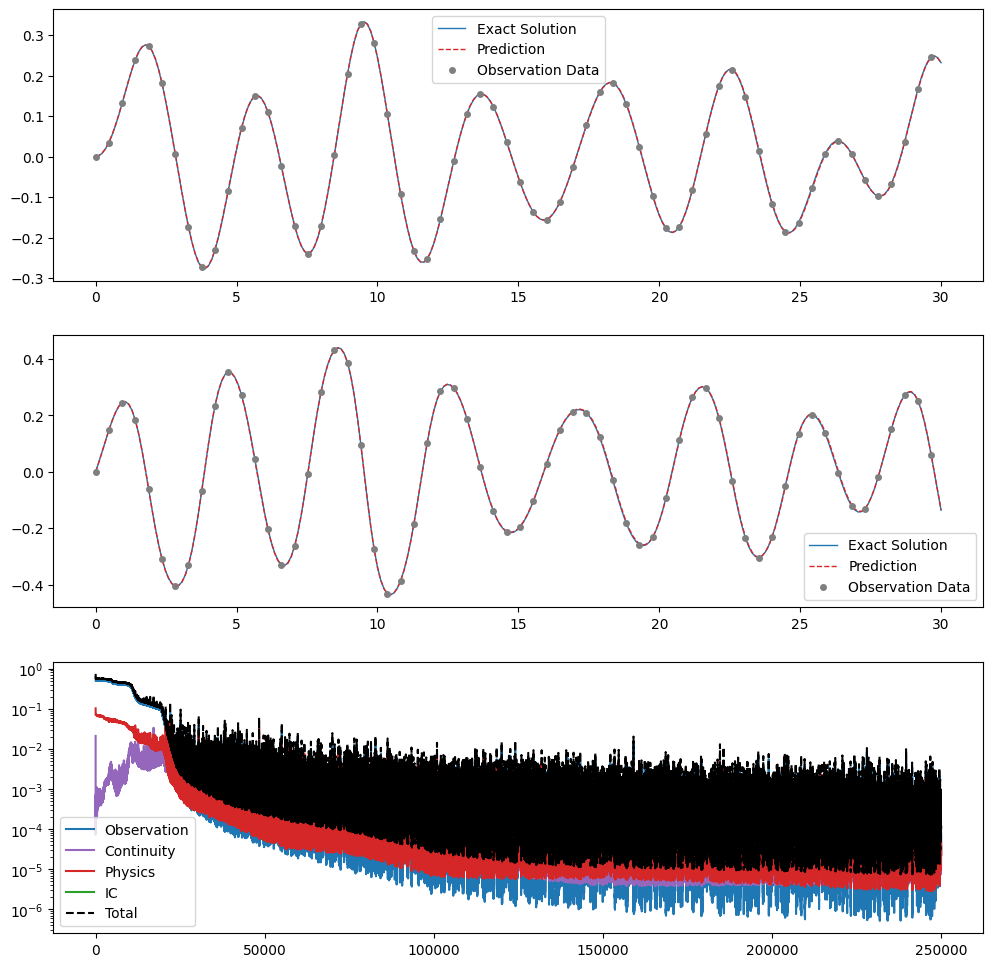

In [16]:
# parse config
parser = argparse.ArgumentParser(description="Train PINN")

# physical-model arguments
parser.add_argument('--n-dof', type=int, default=1)
parser.add_argument('--system-type', type=str, default='single_dof_duffing')
parser.add_argument('--subsample', type=int, default=4)
parser.add_argument('--downsample', type=int, default=1)

# nn-model arguments
parser.add_argument('--model-type', type=str, default='sdof_pinn')
parser.add_argument('--in-channels', type=int, default=1)
parser.add_argument('--latent-features', type=int, default=32)
parser.add_argument('--out-channels', type=int, default=2)

# pinn arguments
parser.add_argument('--phys-system-type', type=str, default='duffing_sdof')
parser.add_argument('--lambdas', type=dict, default={
    'obs' : 1.0,
    'cc' : 1.0,
    'ode' : 1.0,
    'ic' : 0.0
})
parser.add_argument('--system-discovery', type=bool, default=True)
parser.add_argument('--m-', type=torch.Tensor, default=torch.Tensor([[10.0]]))
parser.add_argument('--c-', type=torch.Tensor, default=torch.Tensor([[1.0]]))
parser.add_argument('--k-', type=torch.Tensor, default=torch.Tensor([[15.0]]))
parser.add_argument('--kn-', type=torch.Tensor, default=torch.Tensor([[100.0]]))

# training arguments
parser.add_argument('--task', type=str, default="instance")
parser.add_argument('--batch-size', type=int, default=16)
parser.add_argument('--num-workers', type=int, default=0)
parser.add_argument('--num-epochs', type=int, default=250000)
parser.add_argument('--sequence-length', type=int, default=1)
parser.add_argument('--learning-rate', type=float, default=5e-4)
parser.add_argument('--weight-decay', type=float, default=0)

args = parser.parse_args(args=[])

model = main(args)